<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Generasi_Teks_dengan_tokenisasi_subword.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cell 1: **Install SentencePiece**

In [ ]:
# Jalankan ini di Colab/Jupyter (hanya sekali)
!pip install sentencepiece -q

## Cell 2: **Import Library**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sentencepiece as spm
import matplotlib.pyplot as plt
import requests
import os

## Cell 3: **Download Dataset Bahasa Indonesia**

In [ ]:
# Download file dengan requests
url = "https://raw.githubusercontent.com/hyulianton/datakuliah/refs/heads/main/nietzsche-ID.txt"
response = requests.get(url)
text_path = "nietzsche-ID.txt"
with open(text_path, "w", encoding="utf-8") as f:
    f.write(response.text.lower())

# Cek sebagian isi
with open(text_path, "r", encoding="utf-8") as f:
    sample_text = f.read(500)
print("Contoh isi data:\n", sample_text)

Contoh isi data:
 prakata

seandainya kebenaran adalah seorang wanita—lantas bagaimana? tidakkah ada alasan untuk mencurigai bahwa semua filsuf, sejauh mereka adalah dogmatis, telah gagal memahami wanita—bahwa keseriusan yang mengerikan dan desakan yang canggung yang biasanya mereka tunjukkan dalam mendekati kebenaran, merupakan metode yang tidak terampil dan tidak pantas untuk memenangkan seorang wanita? tentu saja dia tidak pernah membiarkan dirinya dimenangkan; dan saat ini setiap jenis dogma berdiri dengan si


## Cell 4: **Train SentencePiece Model & Tokenize**
_Ini akan membuat tokenizer subword baru dari data Anda._
- SentencePiece memecah kata/kalimat menjadi subword token id.
- `vocab_size` dapat Anda eksperimen untuk hasil optimal.

In [ ]:
# Buat model SentencePiece
spm_model = "spm.model"
spm_vocab = "spm.vocab"
vocab_size = 322  # Ubah sesuai kebutuhan dataset (1000–5000 untuk dataset menengah)

spm.SentencePieceTrainer.Train(input=text_path,
                              model_prefix="spm",
                              vocab_size=vocab_size,
                              pad_id=0, unk_id=1, bos_id=2, eos_id=3)

# Load model
sp = spm.SentencePieceProcessor(model_file=spm_model)

# Tokenisasi subword ke id
with open(text_path, "r", encoding="utf-8") as f:
    text_all = f.read()
tokens = sp.encode(text_all, out_type=int)
print("Contoh 30 id token:", tokens[:30])
print("Jumlah total token dalam data:", len(tokens))

Contoh 30 id token: [21, 39, 206, 10, 239, 279, 156, 29, 25, 10, 125, 61, 101, 20, 31, 5, 58, 4, 52, 138, 12, 149, 27, 15, 147, 29, 118, 182, 4, 38]
Jumlah total token dalam data: 1052


## Cell 5: **Siapkan Input Sequence untuk Training**
- Input: urutan `window_size` token subword.
- Target: token berikutnya (subword).


In [ ]:
window_size = 20  # Subword token window, bisa dikurangi/ditambah sesuai data
X, y = [], []

for i in range(window_size, len(tokens)):
    X.append(tokens[i - window_size:i])
    y.append(tokens[i])
X = np.array(X)
y = keras.utils.to_categorical(y, num_classes=vocab_size)
print("Shape X:", X.shape, "Shape y:", y.shape)

Shape X: (1032, 20) Shape y: (1032, 322)


## Cell 6: **Build LSTM Model**

In [ ]:
model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=window_size),
    layers.LSTM(128),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(vocab_size, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Cell 7: **Train Model dan Simpan History**

In [ ]:
history = model.fit(X, y, batch_size=128, epochs=50, validation_split=0.1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.0080 - loss: 5.7732 - val_accuracy: 0.0577 - val_loss: 5.7675
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0199 - loss: 5.7607 - val_accuracy: 0.0577 - val_loss: 5.7450
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0341 - loss: 5.7012 - val_accuracy: 0.0577 - val_loss: 5.5297
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0271 - loss: 5.5761 - val_accuracy: 0.0577 - val_loss: 5.5397
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0365 - loss: 5.4133 - val_accuracy: 0.0481 - val_loss: 5.5316
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0416 - loss: 5.4047 - val_accuracy: 0.0481 - val_loss: 5.4893
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0400 - loss: 5.2827 - val_accuracy: 0.0481 - val_loss: 5.5149
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0309 - loss: 5.2773 - val_accuracy: 0.0481 - val_loss: 5.5066


## Cell 8: **Visualisasi Akurasi dan Loss**

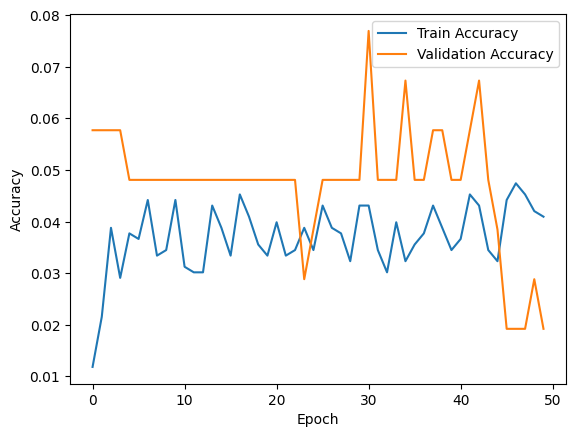

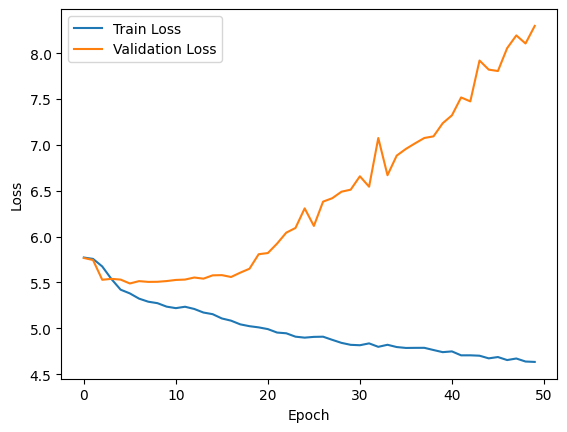

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

## Cell 9: **Text Generation dengan SentencePiece**
- Seed text di-tokenisasi ke id dengan SentencePiece.
- Model memprediksi token subword berikutnya.
- Hasil id di-decode ke text dengan SentencePiece.

In [ ]:
def generate_text(seed_text, next_tokens=40, temperature=0.8):
    sp_ids = sp.encode(seed_text, out_type=int)
    generated = sp_ids[:]
    for _ in range(next_tokens):
        input_seq = tf.keras.preprocessing.sequence.pad_sequences([generated[-window_size:]],
                                                                 maxlen=window_size)
        preds = model.predict(input_seq, verbose=0)[0]
        preds = np.log(preds + 1e-8) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        next_id = np.random.choice(vocab_size, p=preds)
        generated.append(next_id)
    # Decode back to text
    out_text = sp.decode(generated)
    return out_text

seed = "kebenaran adalah"
print("Input seed:", seed)
print("Output:\n", generate_text(seed, next_tokens=40, temperature=0.8))

Input seed: kebenaran adalah
Output:
 kebenaran adalahng terlalu dogmatisputraanjitaentuiuntukan bdekat tumidasar keasaniangatkwaahan  wanitab su alara lnyaan termbuenganur


### **Ringkasan:**
- **Tokenisasi subword** membuat model lebih robust pada kata/variasi baru.
- **SentencePiece** populer di NLP modern (dipakai oleh BERT, T5, dsb.).
- Training & inference seperti sebelumnya, hanya input/output diubah jadi id subword.